In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch

In [3]:
filters_models = pd.read_pickle("filters-models.pkl")
filters_models.head()

,fish_id,zone,input_noise_std,model_id,model_filter,model_bias,train_error,valid_error
0,fish,dlz,0.05,0,"[0.006570485, 0.02226457, 0.006591105, 0.05336...",-0.125259,0.234976,0.223262
1,fish,dlz,0.05,1,"[-0.0078074387, -0.015862474, -0.010496924, -0...",-0.112887,0.229159,0.227332
2,fish,dlz,0.05,10,"[-0.025499035, 0.054145638, 0.032702055, 0.031...",-0.088350,0.233271,0.237094
3,fish,dlz,0.05,11,"[-0.0053257598, -0.0764562, 0.030652717, 0.012...",-0.070196,0.231950,0.232991
4,fish,dlz,0.05,12,"[-0.020457136, -0.030005453, 0.03785134, -0.00...",-0.076064,0.228166,0.231957


### Plot distributions of train and valid errors

In [4]:
train_errors = filters_models[["input_noise_std", "train_error", "zone"]].copy()
train_errors["error"] = train_errors["train_error"]
train_errors.drop(columns="train_error", inplace=True)
train_errors["set"] = "train"

valid_errors = filters_models[["input_noise_std", "valid_error", "zone"]].copy()
valid_errors["error"] = valid_errors["valid_error"]
valid_errors.drop(columns="valid_error", inplace=True)
valid_errors["set"] = "valid"

filters_models_errors = pd.concat(
    [train_errors, valid_errors],
    axis=0,
    ignore_index=True,
)

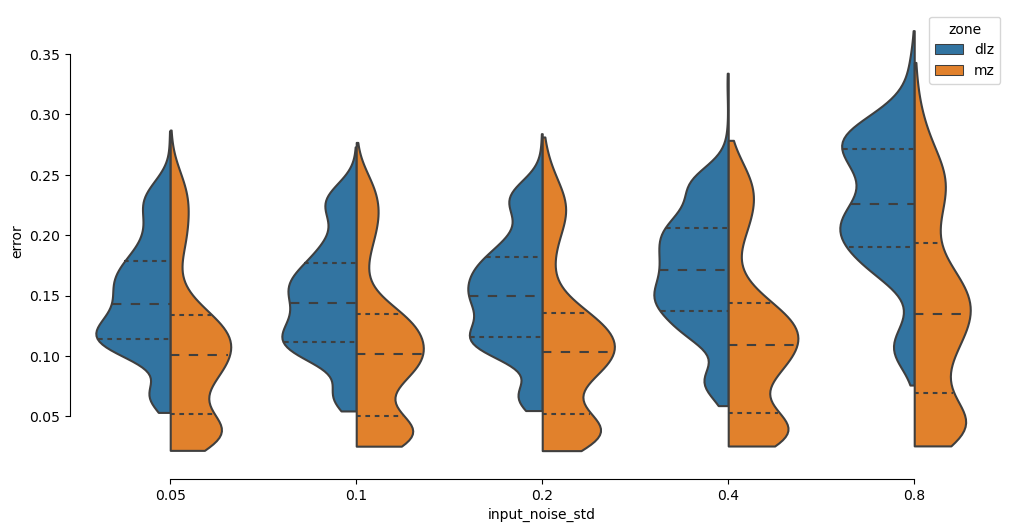

In [7]:
plt.figure(figsize=(12, 6))
sns.violinplot(data=valid_errors, x="input_noise_std", y="error", hue="zone", cut=0, split=True, inner="quart")
sns.despine(offset=5, trim=True)

/opt/anaconda3/envs/efish/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/efish/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Figure size 1200x600 with 0 Axes>

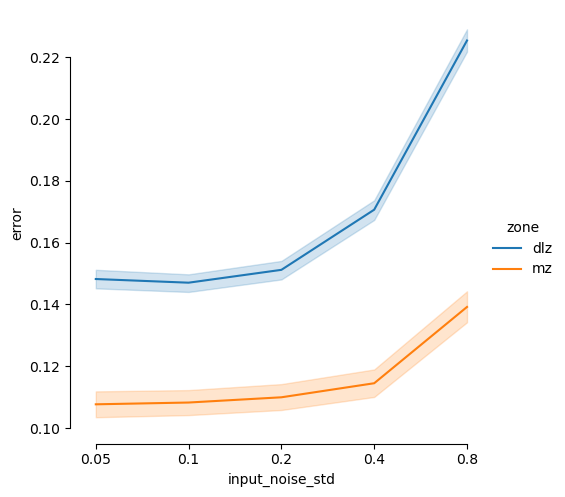

In [32]:
plt.figure(figsize=(12, 6))
sns.relplot(data=valid_errors, x="input_noise_std", y="error", hue="zone", kind="line")
plt.xscale("log")
plt.minorticks_off()
plt.xticks(valid_errors["input_noise_std"].unique(), valid_errors["input_noise_std"].unique())
sns.despine(offset=5, trim=True)

### Plot filters with mean and std across random inits

(80, 1005)


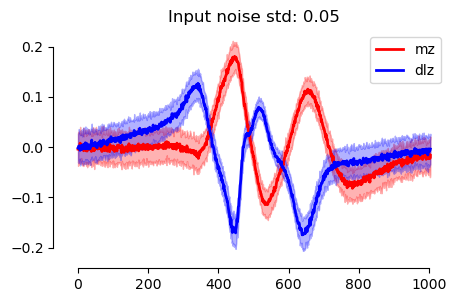

(80, 1005)


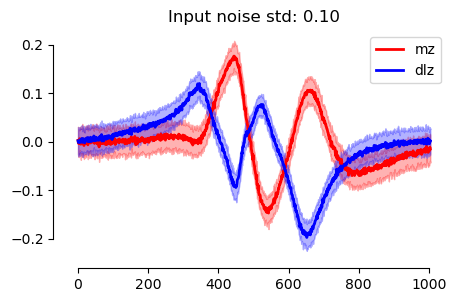

(80, 1005)


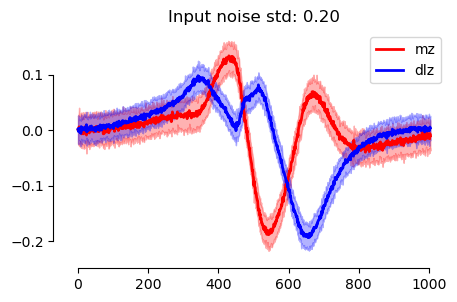

(80, 1005)


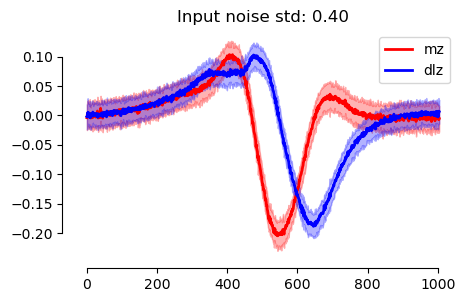

(80, 1005)


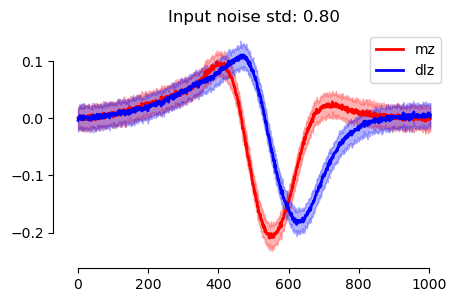

""


In [49]:
def plot_filters(dfgroup):
    plt.figure(figsize=(5, 3))
    filters = np.vstack(dfgroup[dfgroup["zone"] == "mz"]["model_filter"])
    print(filters.shape)
    # plt.plot(coefficients.T, color="black", alpha=0.1, lw=0.1)
    plt.plot(filters.mean(axis=0), color="red", lw=2, label="mz")
    plt.fill_between(
        x=np.arange(filters.shape[1]),
        y1=filters.mean(axis=0) - filters.std(axis=0),
        y2=filters.mean(axis=0) + filters.std(axis=0),
        color="red",
        alpha=0.3,
    )
    filters = np.vstack(dfgroup[dfgroup["zone"] == "dlz"]["model_filter"])
    # plt.plot(coefficients.T, color="black", alpha=0.1, lw=0.1)
    plt.plot(filters.mean(axis=0), color="blue", lw=2, label="dlz")
    plt.fill_between(
        x=np.arange(filters.shape[1]),
        y1=filters.mean(axis=0) - filters.std(axis=0),
        y2=filters.mean(axis=0) + filters.std(axis=0),
        color="blue",
        alpha=0.3,
    )
    sns.despine(offset=5, trim=True)
    plt.title(f"Input noise std: {dfgroup['input_noise_std'].iloc[0]:.2f}")
    plt.legend()
    plt.show()
    plt.close()
    pass


filters_models[filters_models["fish_id"]=="fish"].groupby("input_noise_std").apply(plot_filters)

### Compute and plot smooth filters

In [47]:
def smooth_filters(dfgroup):
    model_filter = np.vstack(dfgroup["model_filter"]).mean(0)
    
    smoothing_filter_size = 51
    smoothing_filter = np.exp(-((np.arange(smoothing_filter_size)-smoothing_filter_size/2) / (smoothing_filter_size/4))**2)
    smoothing_filter = smoothing_filter / smoothing_filter.sum()
    model_filter = np.convolve(model_filter, smoothing_filter, mode="same")
    
    model_filter = model_filter / model_filter.max()
    
    return model_filter

smooth_filters = filters_models.groupby(["fish_id", "zone", "input_noise_std"]).apply(smooth_filters).reset_index(name="model_filter")

In [54]:
smooth_filters["model_filter"]

(1005,)

(2, 4)


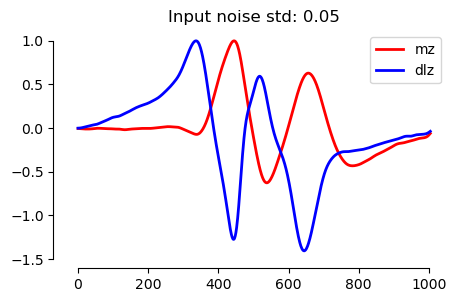

(2, 4)


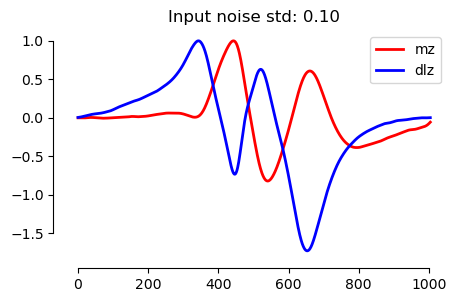

(2, 4)


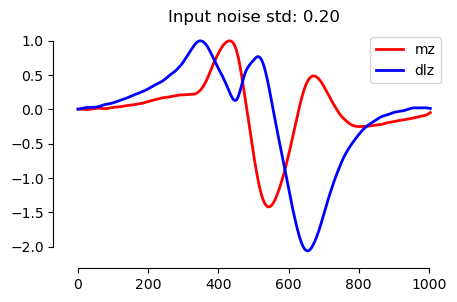

(2, 4)


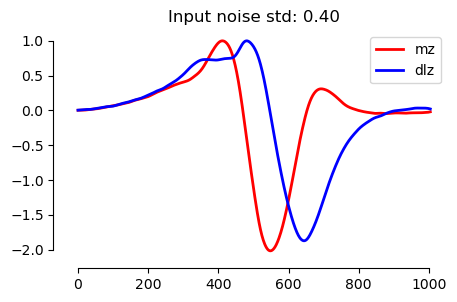

(2, 4)


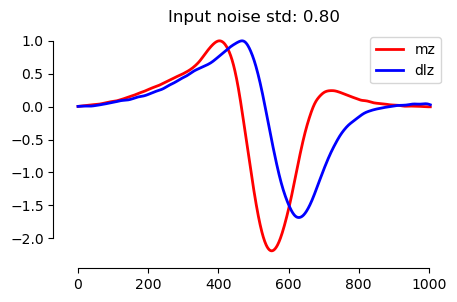

""


In [57]:
def plot_smooth_filters(dfgroup):
    print(dfgroup.shape)
    plt.figure(figsize=(5, 3))

    filters = dfgroup[dfgroup["zone"] == "mz"]["model_filter"].iloc[0]
    plt.plot(filters, color="red", lw=2, label="mz")

    filters = dfgroup[dfgroup["zone"] == "dlz"]["model_filter"].iloc[0]
    plt.plot(filters, color="blue", lw=2, label="dlz")

    sns.despine(offset=5, trim=True)
    plt.title(f"Input noise std: {dfgroup['input_noise_std'].iloc[0]:.2f}")
    plt.legend()
    plt.show()
    plt.close()
    pass


smooth_filters[smooth_filters["fish_id"] == "fish"].groupby("input_noise_std").apply(plot_smooth_filters)

### Save filters to .csv for easy loading

In [77]:
saved_filters_training_noise = 0.4
saved_filters = smooth_filters[
    (smooth_filters["fish_id"] == "fish") & (smooth_filters["input_noise_std"] == saved_filters_training_noise)
]
saved_filters.index = saved_filters["zone"]
saved_filters = saved_filters.drop(columns=["fish_id", "zone", "input_noise_std"])
saved_filters = pd.DataFrame(dict(mz=saved_filters.T["mz"]["model_filter"], dlz=saved_filters.T["mz"]["model_filter"]))
saved_filters.to_csv(f"../data/filters/fish-filters-{str(saved_filters_training_noise).replace('.', 'p')}.csv", index=False)

In [74]:
saved_filters = pd.read_csv("../data/filters/fish_filters.csv")